# Double Peaks in COVID-19
This workbook looks for double peaks in COVID-19 cases by state.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
import scipy.optimize as opt
from datetime import datetime, timedelta
from data_mappings import state_full_names

In [2]:
states = pd.read_csv("https://covidtracking.com/api/states/daily.csv")
states['date'] = pd.to_datetime(states['date'],format='%Y%m%d')
states['state'] = states['state'].map(state_full_names)
states.rename(columns={
    'death': 'deaths',
    'deathIncrease': 'new_deaths',
    'positive': 'cases',
    'positiveIncrease': 'new_cases',
    'hospitalizedIncrease': 'new_hospitalizations',
    'onVentilatorCurrently': 'on_ventilator',
    'inIcuCurrently': 'in_icu'
},inplace=True)
states = states.sort_values(by=['state','date'])

In [3]:
los = sorted(states.state.unique())
for state in los:
    tmp = states[states.state == state]
    states.loc[tmp.index,'nc7d'] = states.loc[tmp.index,'new_cases'].rolling(window=7).mean()
    states.loc[tmp.index,'nd7d'] = states.loc[tmp.index,'new_deaths'].rolling(window=7).mean()
    states.loc[tmp.index,'ntri7d'] = states.loc[tmp.index,'totalTestResultsIncrease'].rolling(window=7).mean()
    states.loc[tmp.index,'new_recovered'] = states.loc[tmp.index,'recovered'] - states.loc[tmp.index,'recovered'].shift(1)
    states.loc[tmp.index,'rec7d'] = states.loc[tmp.index,'new_recovered'].rolling(window=7).mean()
states.replace(np.nan,0,inplace=True)
states.tail()

,date,state,cases,negative,pending,hospitalizedCurrently,hospitalizedCumulative,in_icu,inIcuCumulative,on_ventilator,...,new_deaths,new_hospitalizations,negativeIncrease,new_cases,totalTestResultsIncrease,nc7d,nd7d,ntri7d,new_recovered,rec7d
279,2020-04-18,Wyoming,305.0,6217.0,0.0,19.0,50.0,0.0,0.0,0.0,...,0.0,7.0,86.0,9.0,95.0,6.285714,0.285714,151.857143,58.0,11.000000
223,2020-04-19,Wyoming,309.0,6972.0,0.0,19.0,50.0,0.0,0.0,0.0,...,0.0,0.0,755.0,4.0,759.0,6.857143,0.285714,260.285714,21.0,12.857143
167,2020-04-20,Wyoming,313.0,7073.0,0.0,19.0,51.0,0.0,0.0,0.0,...,0.0,1.0,101.0,4.0,105.0,5.428571,0.142857,203.142857,6.0,13.571429
111,2020-04-21,Wyoming,320.0,7301.0,0.0,19.0,52.0,0.0,0.0,0.0,...,4.0,1.0,228.0,7.0,235.0,6.428571,0.714286,236.714286,4.0,13.857143
55,2020-04-22,Wyoming,322.0,7301.0,0.0,19.0,52.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,5.000000,0.571429,184.857143,17.0,17.857143


In [4]:
states.columns

Index(['date', 'state', 'cases', 'negative', 'pending',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'in_icu',
       'inIcuCumulative', 'on_ventilator', 'onVentilatorCumulative',
       'recovered', 'hash', 'dateChecked', 'deaths', 'hospitalized', 'total',
       'totalTestResults', 'posNeg', 'fips', 'new_deaths',
       'new_hospitalizations', 'negativeIncrease', 'new_cases',
       'totalTestResultsIncrease', 'nc7d', 'nd7d', 'ntri7d', 'new_recovered',
       'rec7d'],
      dtype='object')

In [5]:
def plot_state(state):
    fig, axes = plt.subplots(2, 2, sharex='col', figsize=(10,8))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    tmp = states[(states.state == state)][-42:]
    fig.suptitle(state, fontsize=14, y=1.02);
    
    has_hospitalization_data = tmp.hospitalizedCurrently.max() + tmp.in_icu.max() + tmp.on_ventilator.max() > 0
    has_recovery_data = tmp.new_recovered.max() > 0

    # top left plot
    ax = axes[0,0]
    ax.bar(tmp.date, tmp.new_cases, label='New Cases', color='tab:orange')
    ax.plot(tmp.date, tmp.nc7d, label='New Cases - 7 day MA')
    ax.legend()
    ax.tick_params(axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # top right plot
    ax = axes[0,1]
    ax.bar(tmp.date, tmp.new_deaths, label='New Deaths', color='tab:orange')
    ax.plot(tmp.date, tmp.nd7d, label='New Deaths - 7 day MA')
    ax.legend()
    ax.tick_params(axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # bottom left plot
    ax = axes[1,0]
    if has_hospitalization_data:
        if tmp.hospitalizedCurrently.max() > 0:
            ax.plot(tmp.date, tmp.hospitalizedCurrently, label='Currently in Hospital')
        if tmp.in_icu.max() > 0:
            ax.plot(tmp.date, tmp.in_icu, label='Currently in ICU')
        if tmp.on_ventilator.max() > 0:
            ax.plot(tmp.date, tmp.on_ventilator, label='Currently on Ventilator')
    else:
        ax.bar(tmp.date, tmp.totalTestResultsIncrease, label='New Test Results', color='tab:orange')
        ax.plot(tmp.date, tmp.ntri7d, label='New Test Results - 7 day MA')
    ax.legend()
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # bottom right plot
    ax = axes[1,1]
    if has_recovery_data:
        ax.bar(tmp.date, tmp.new_recovered, label='Recoveries', color='tab:orange')
        ax.plot(tmp.date, tmp.rec7d, label='Recoveries - 7 day MA')
        ax.legend()        
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    elif has_hospitalization_data:
        ax.bar(tmp.date, tmp.totalTestResultsIncrease, label='New Test Results', color='tab:orange')
        ax.plot(tmp.date, tmp.ntri7d, label='New Test Results - 7 day MA')
        ax.legend()        
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

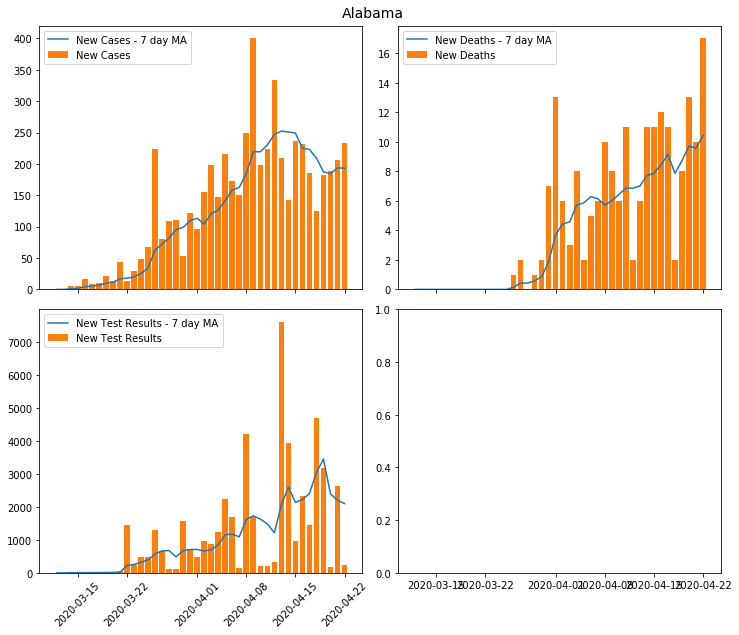

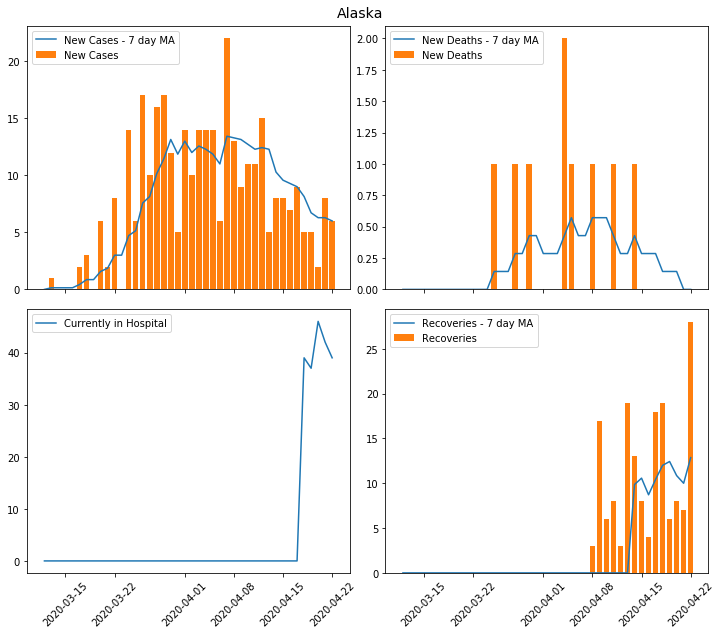

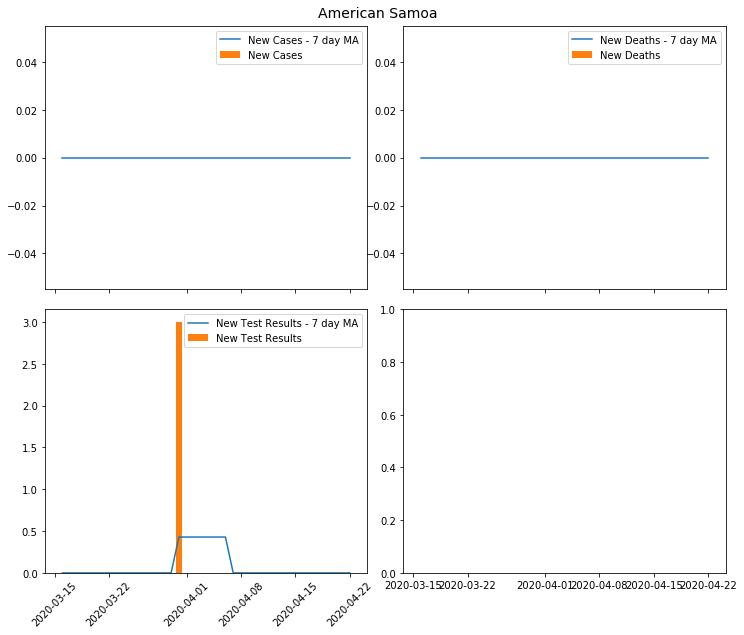

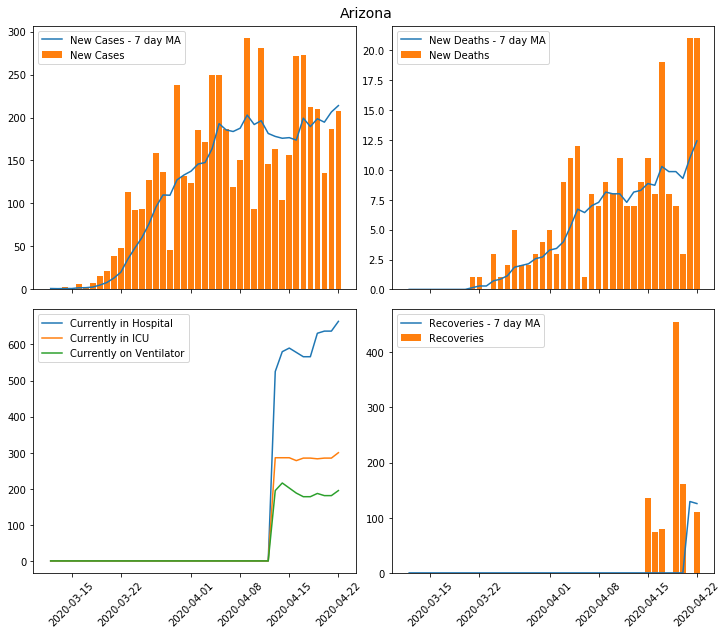

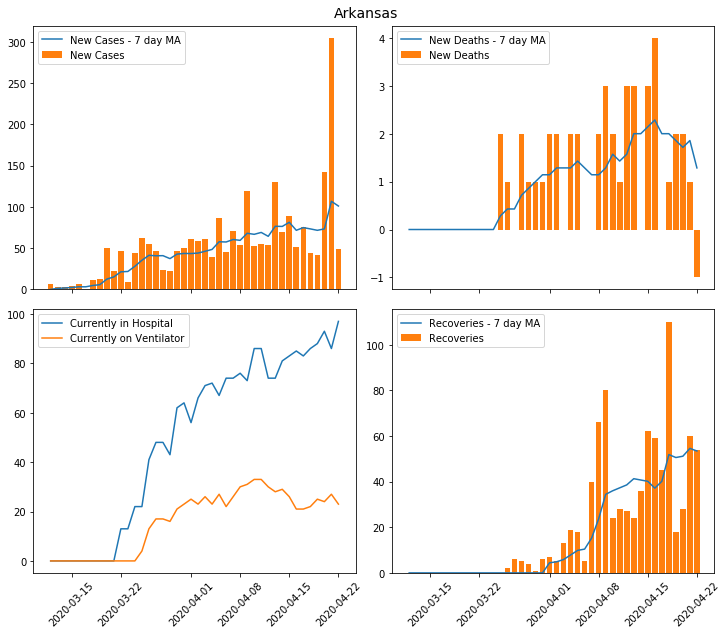

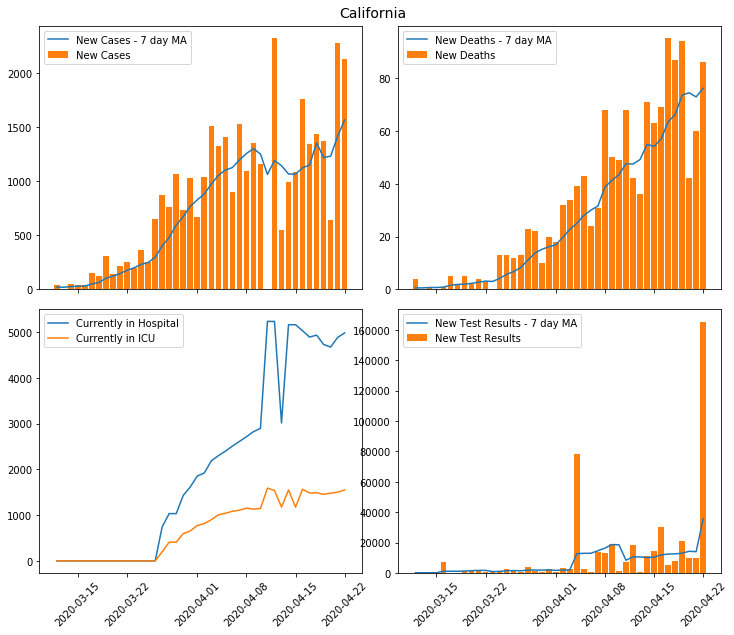

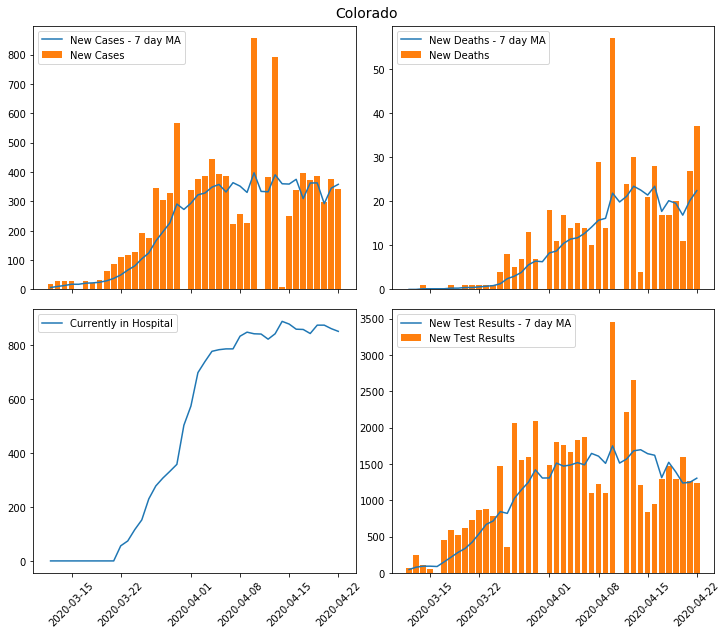

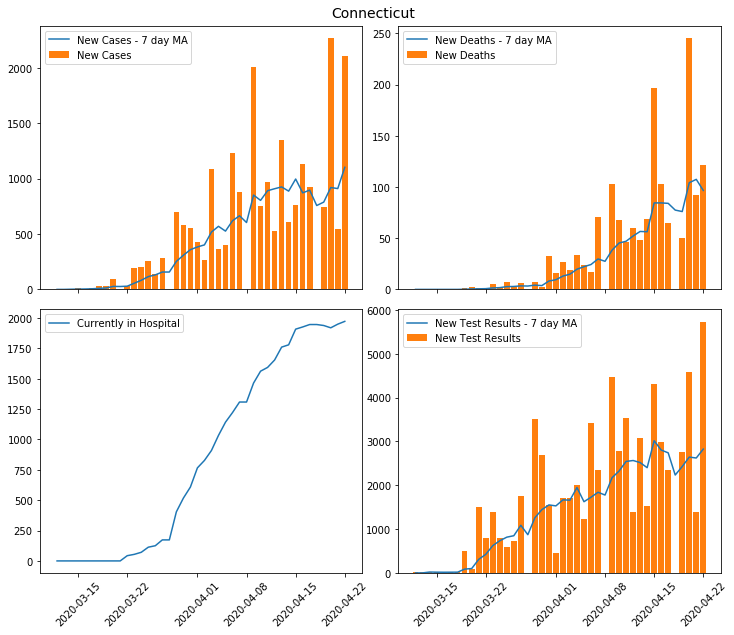

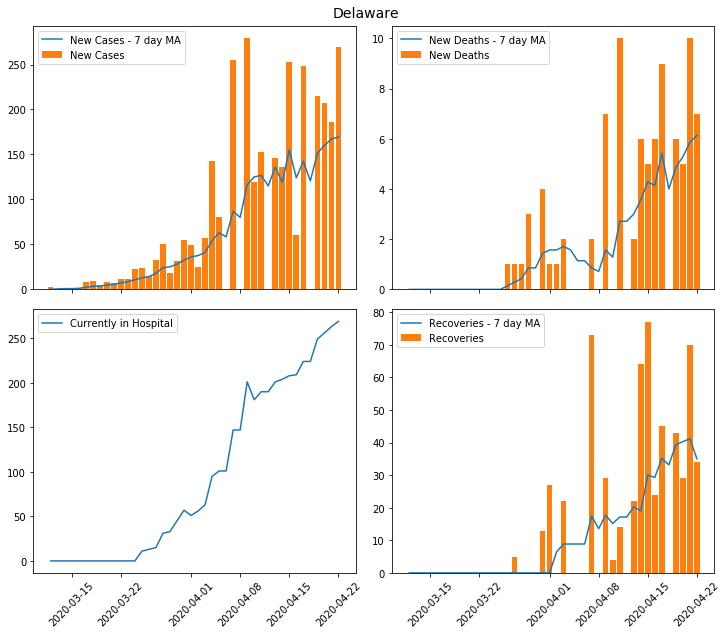

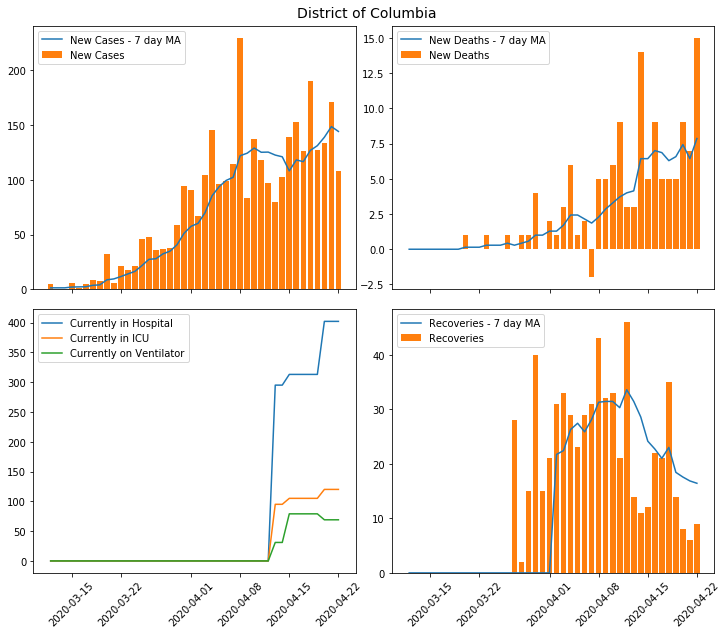

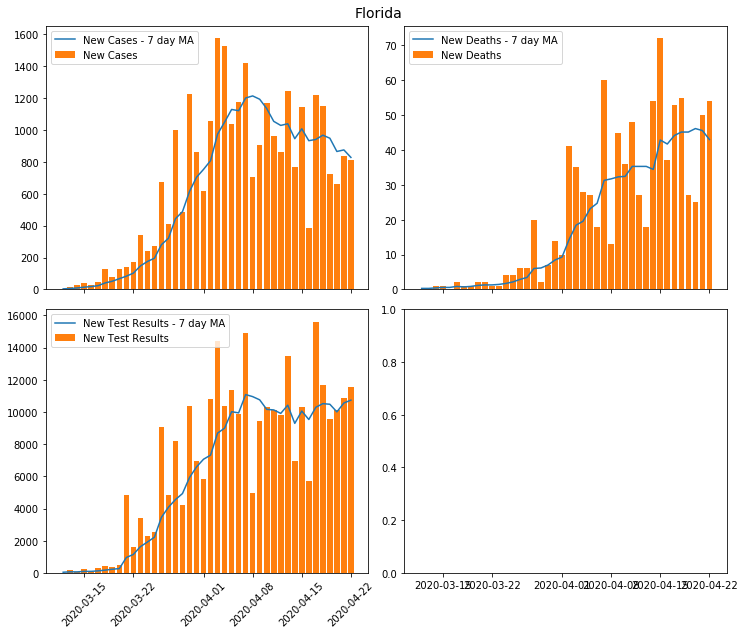

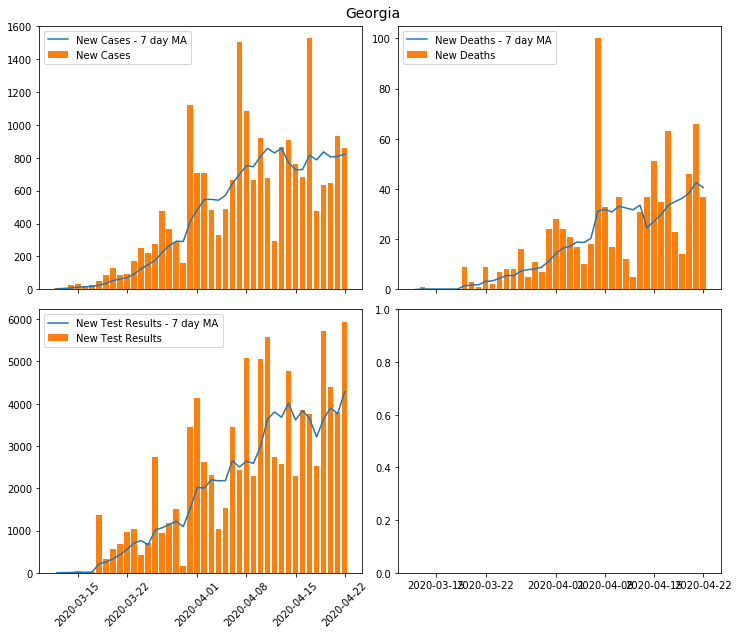

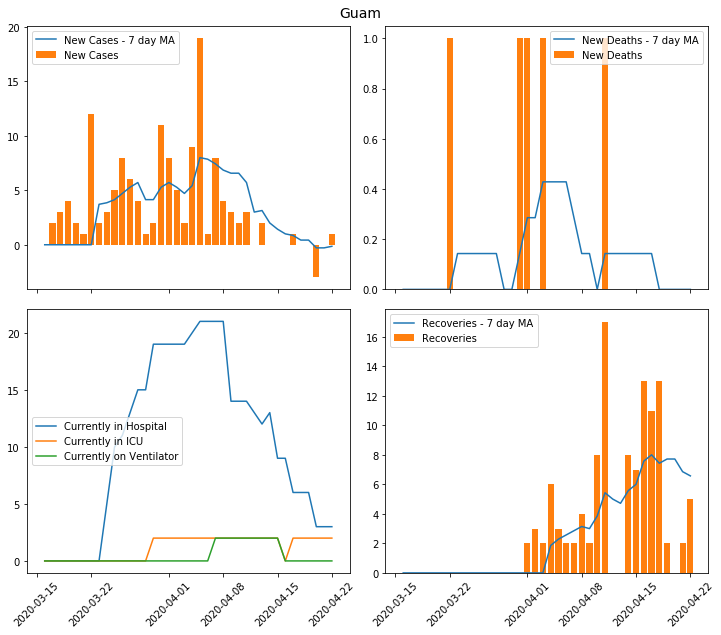

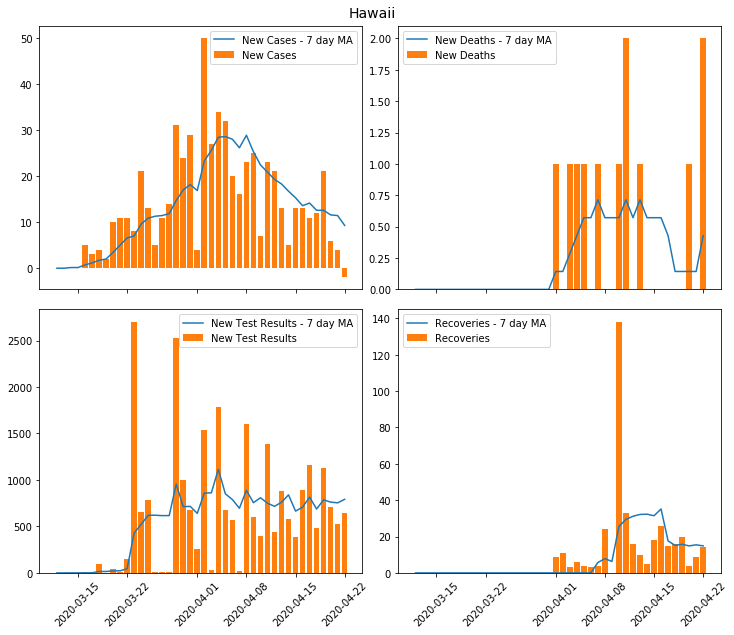

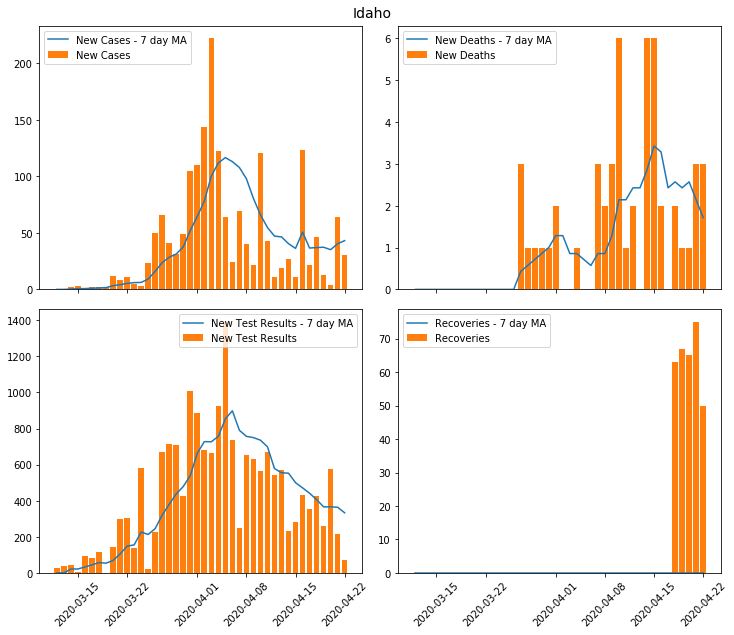

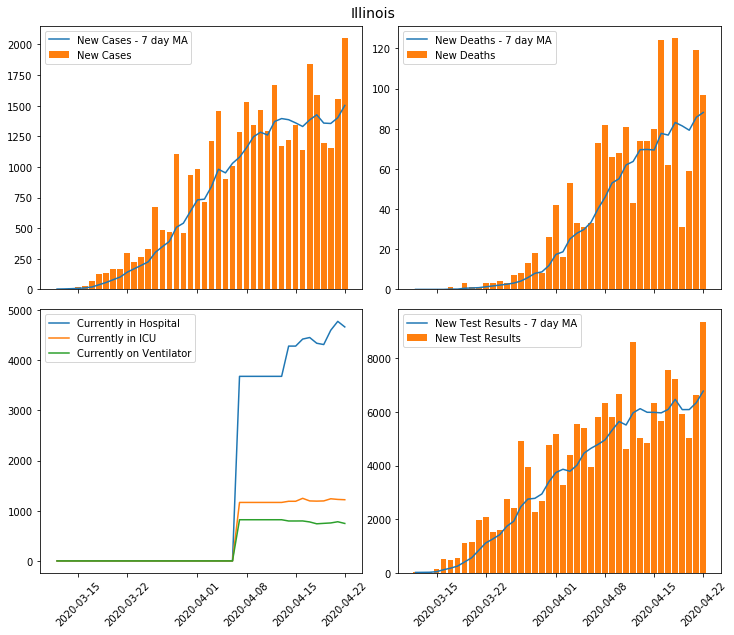

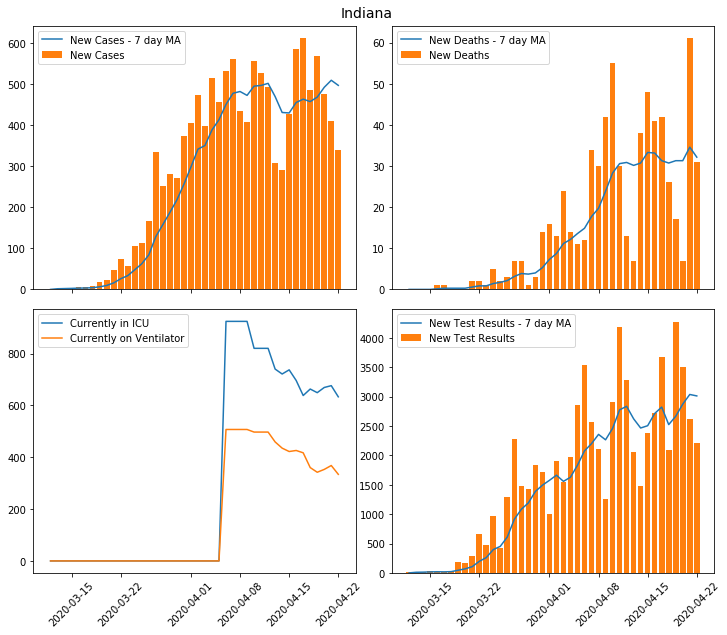

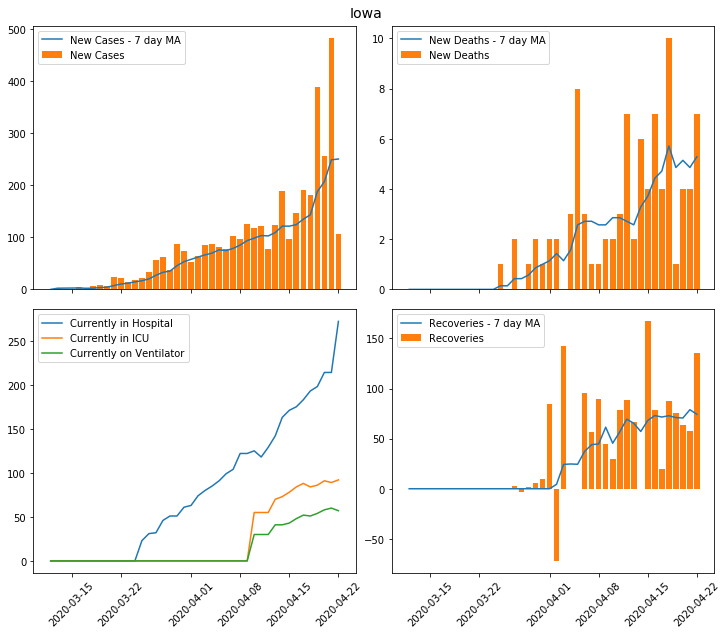

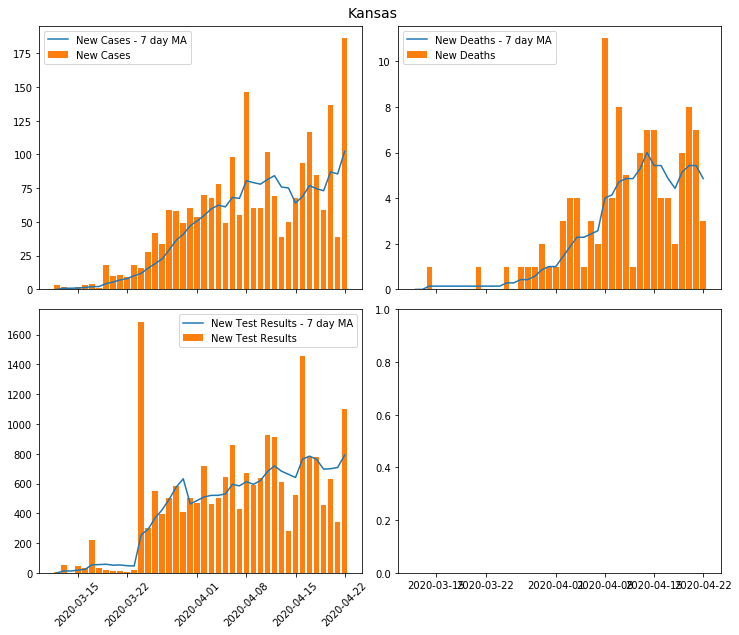

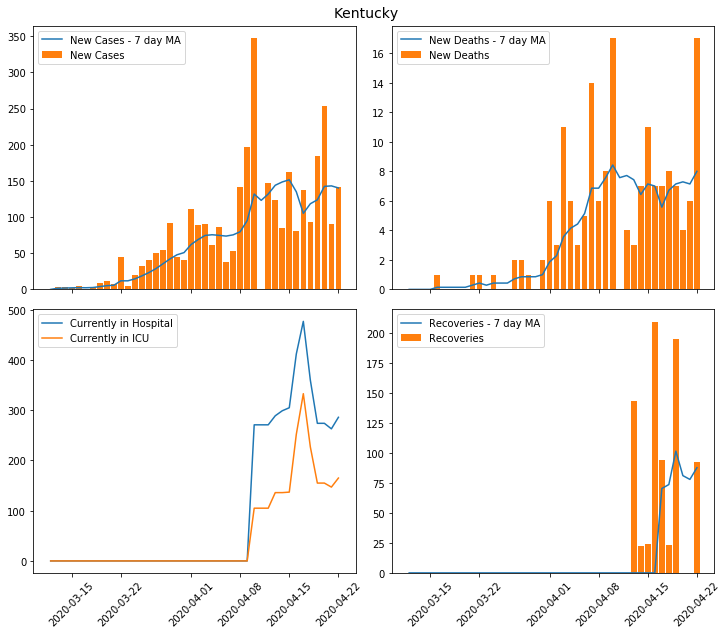

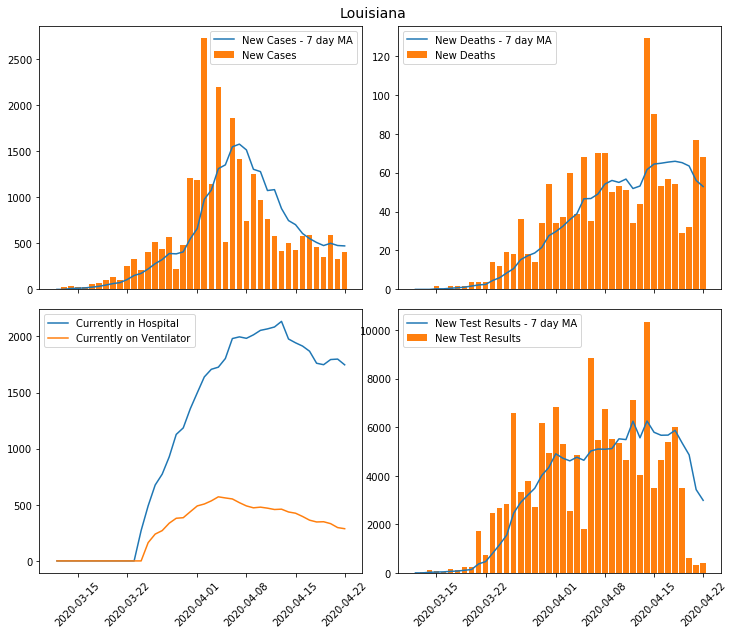

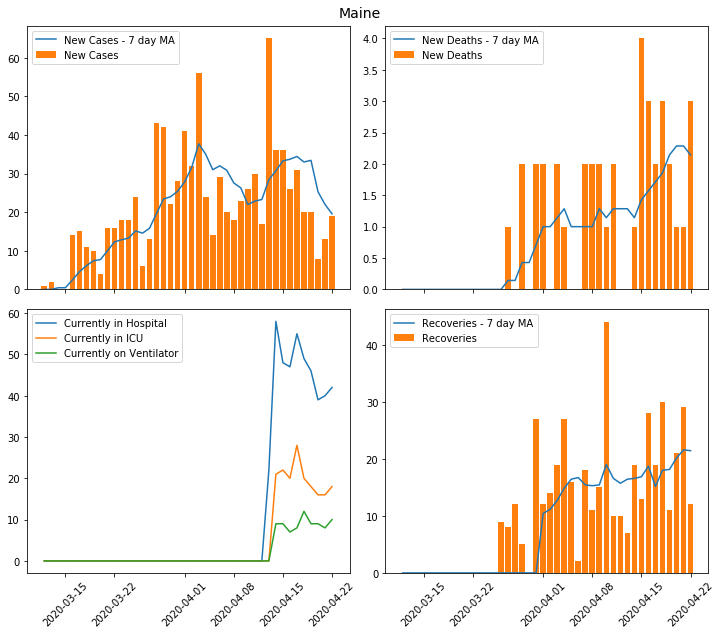

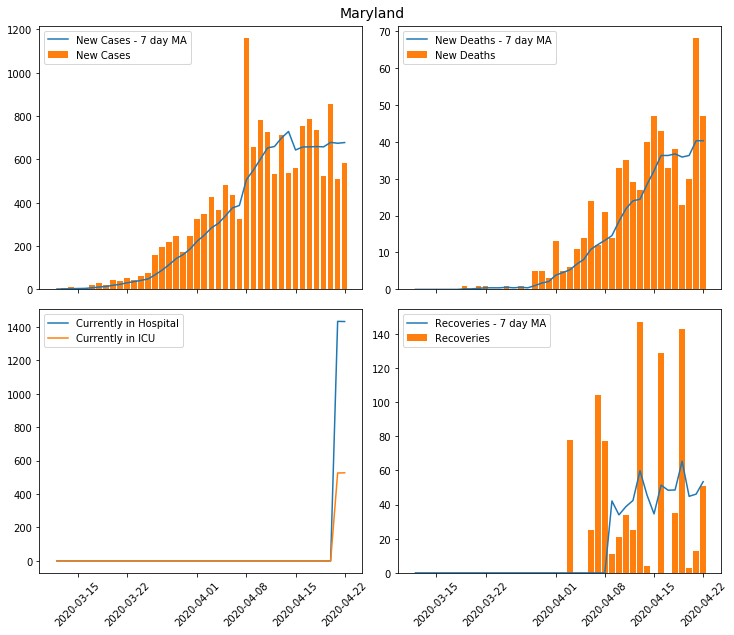

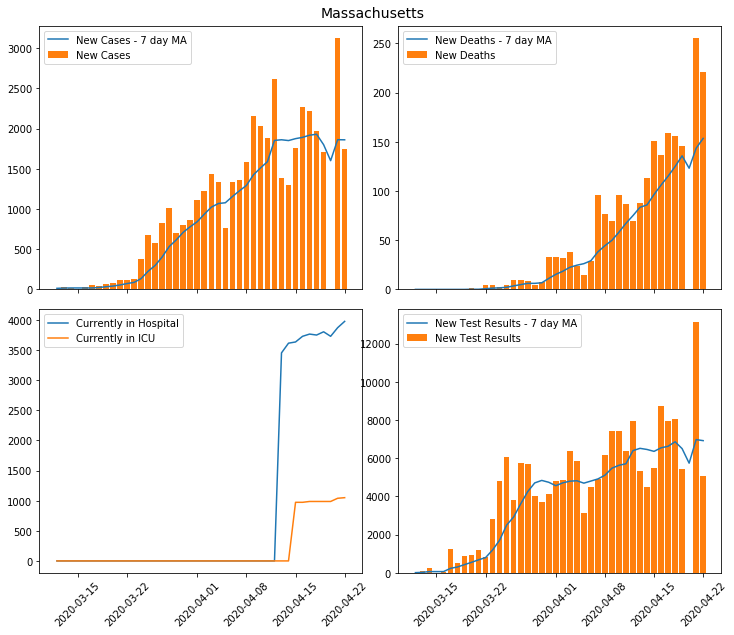

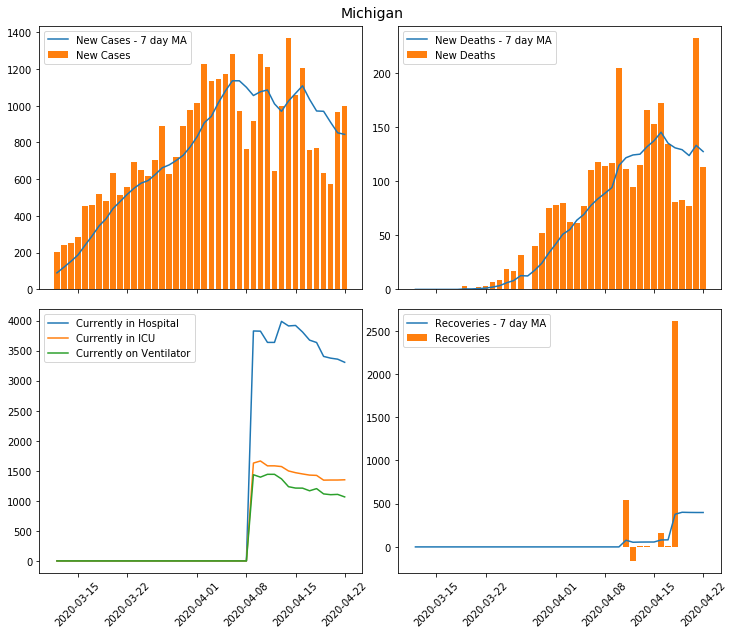

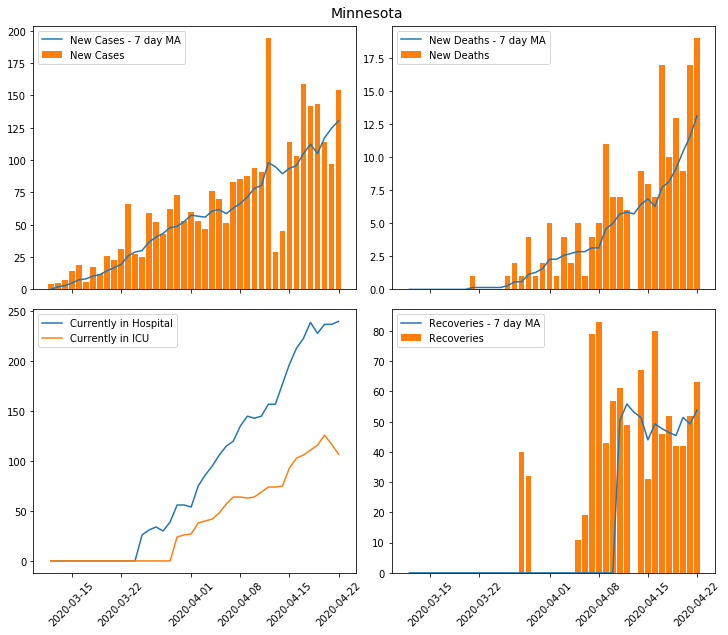

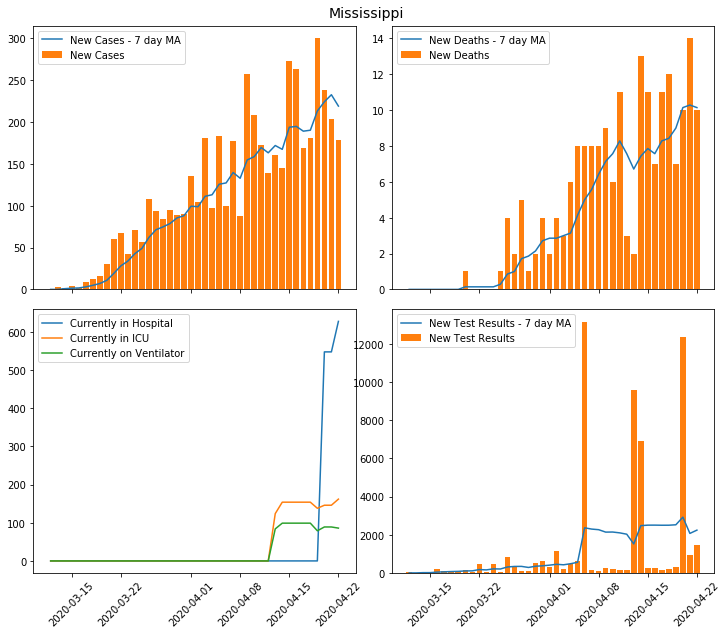

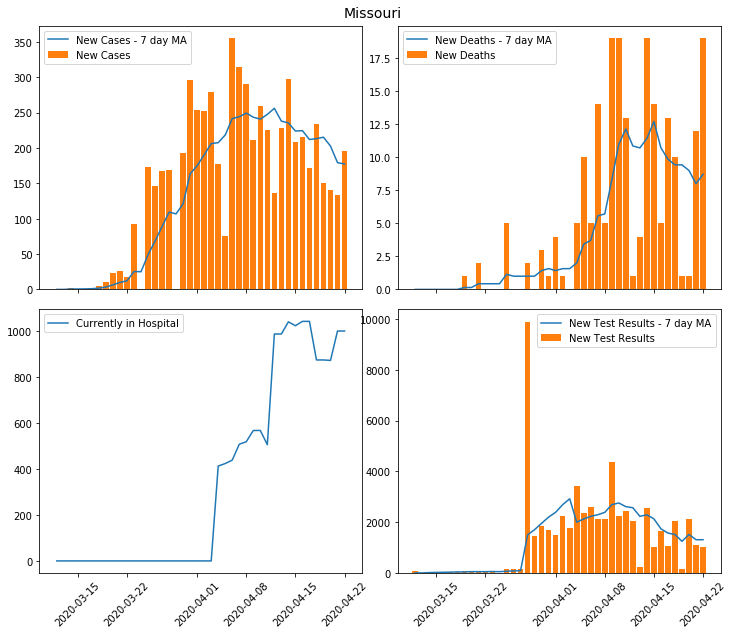

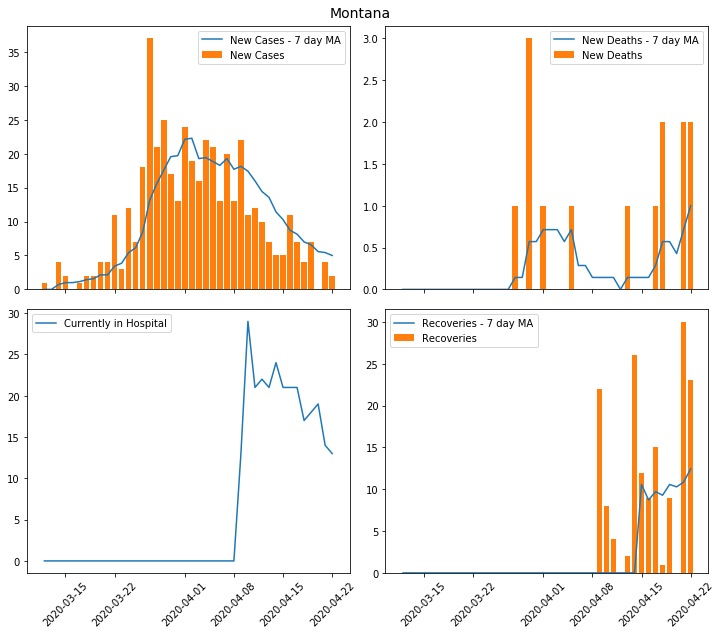

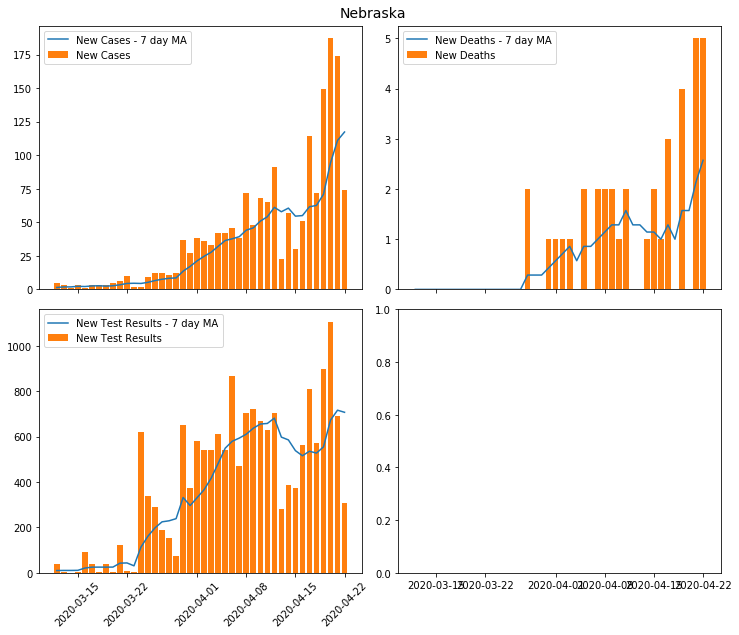

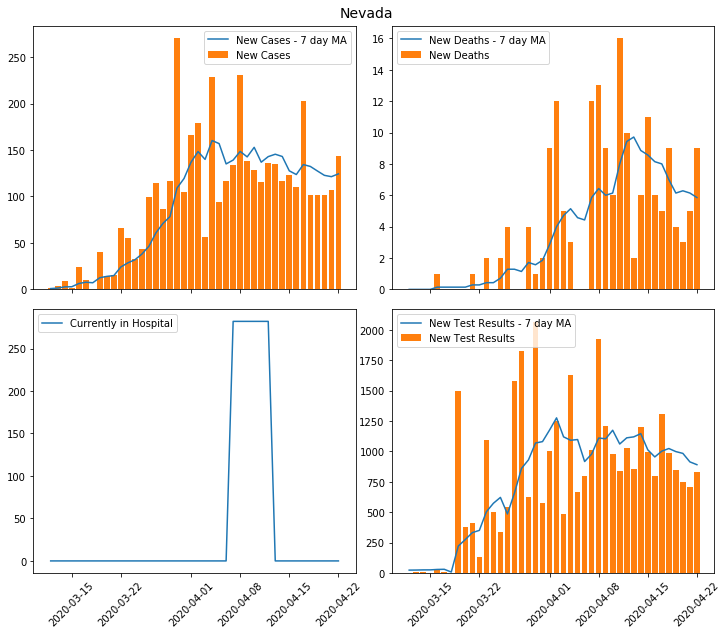

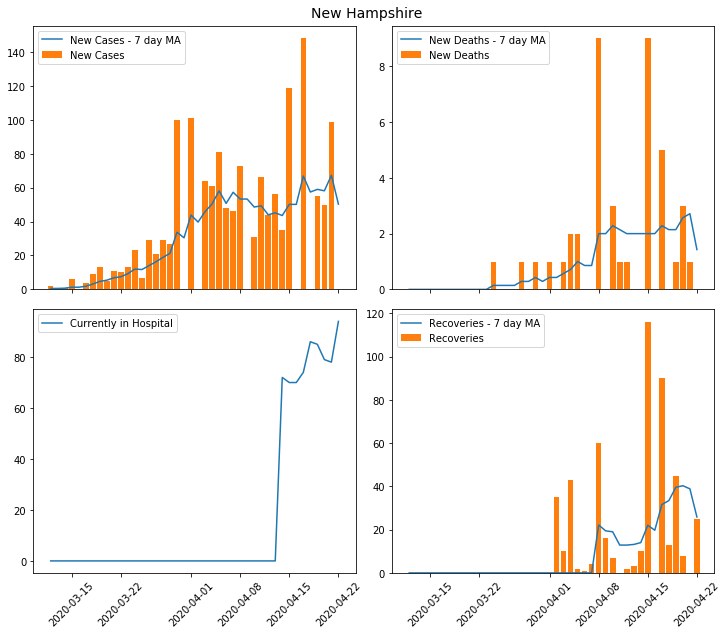

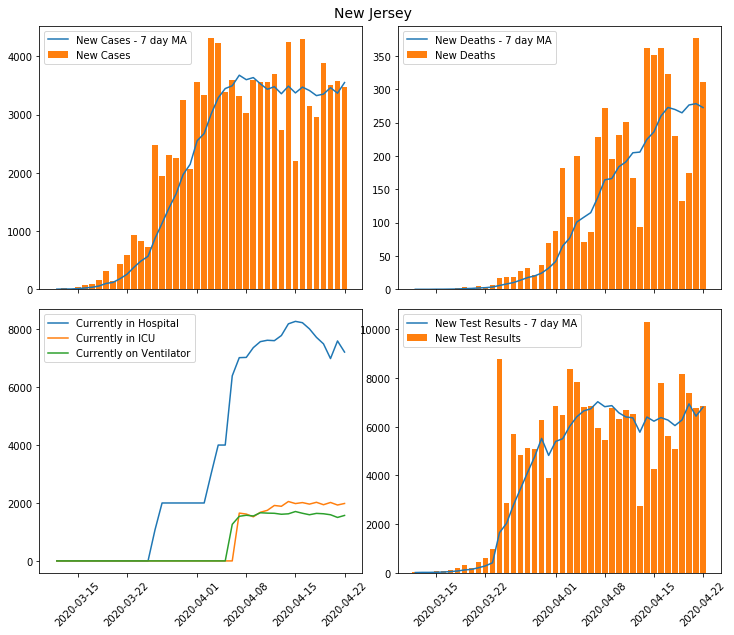

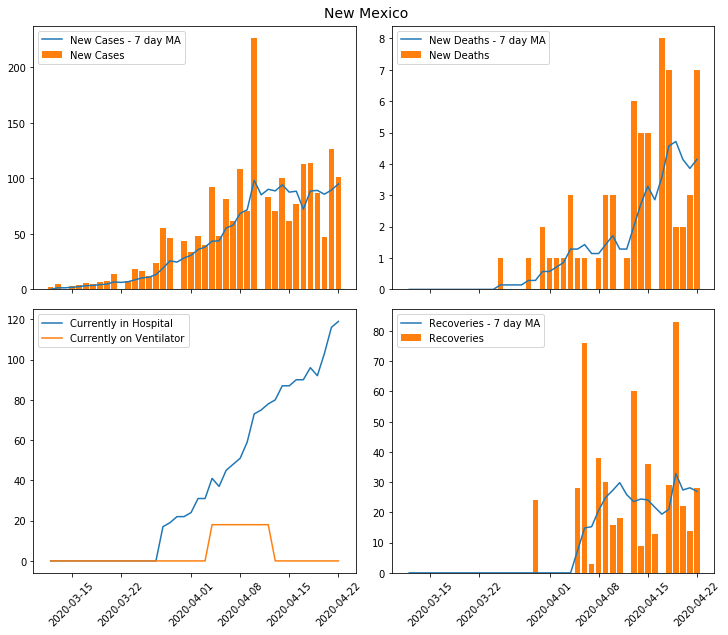

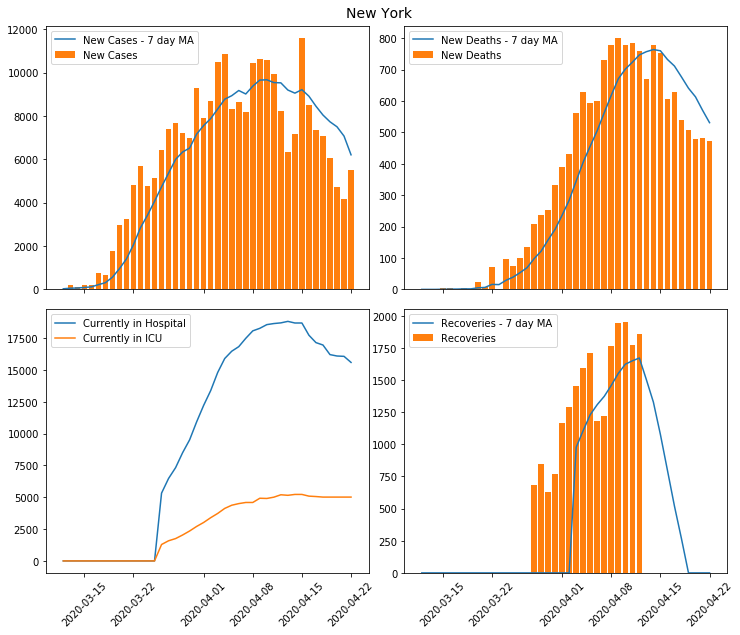

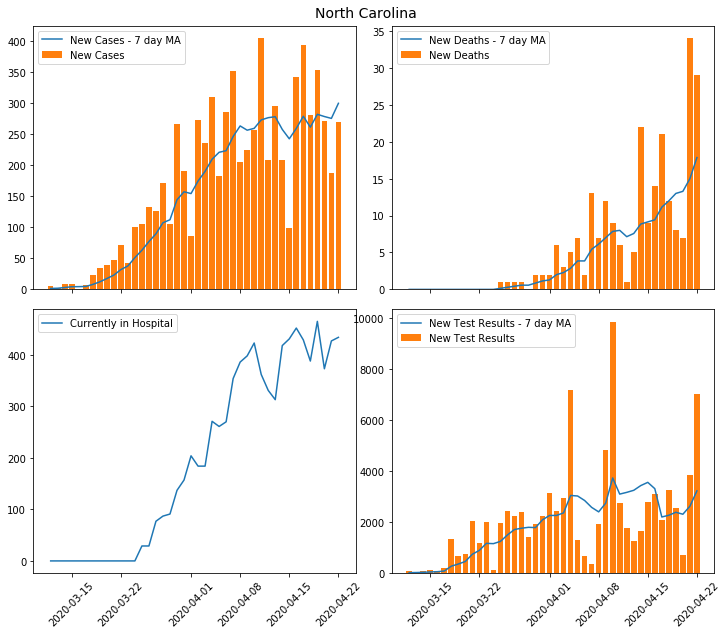

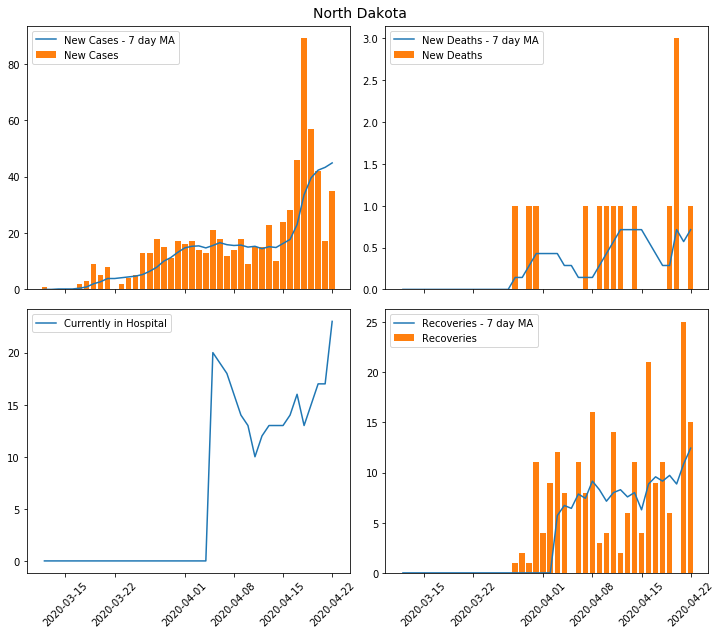

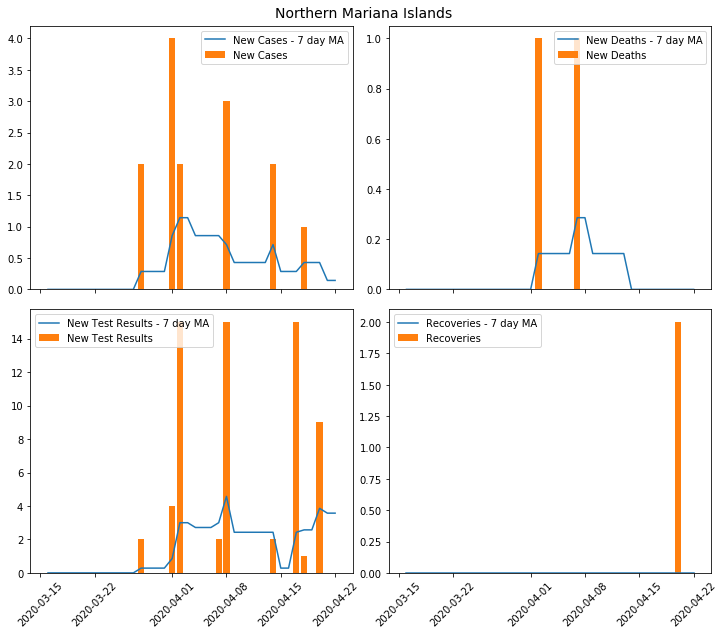

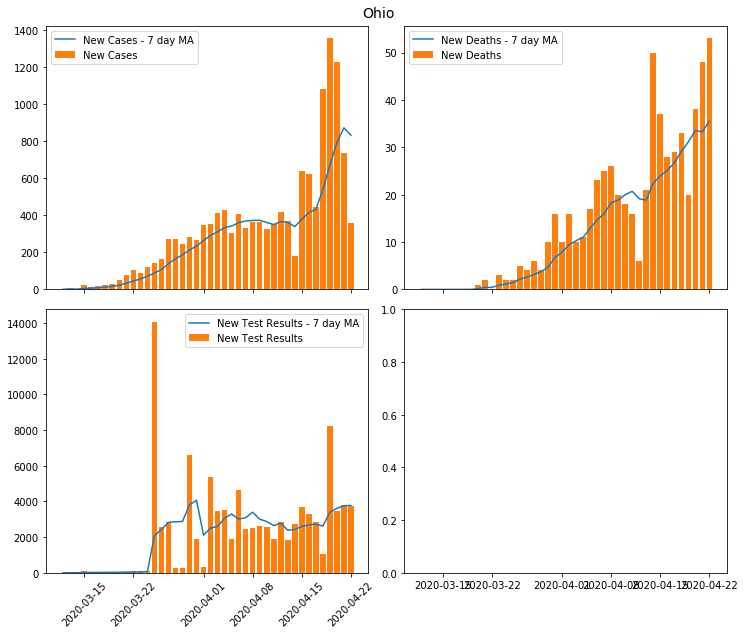

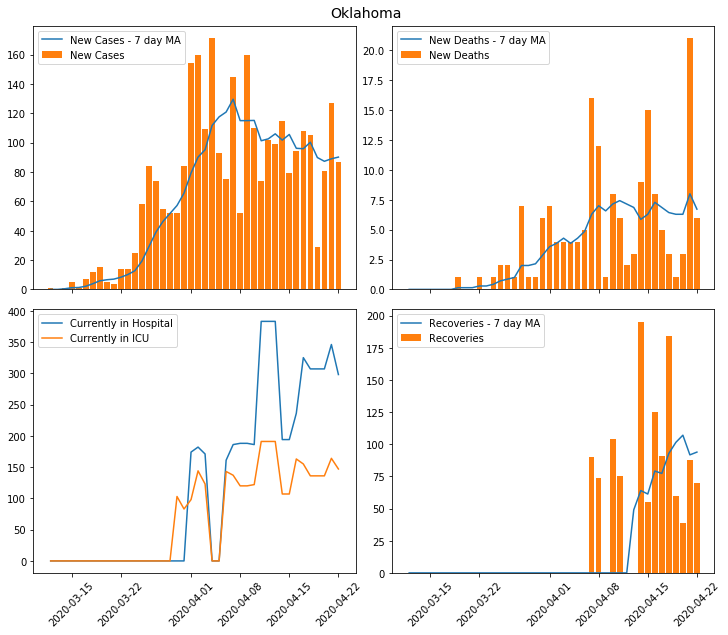

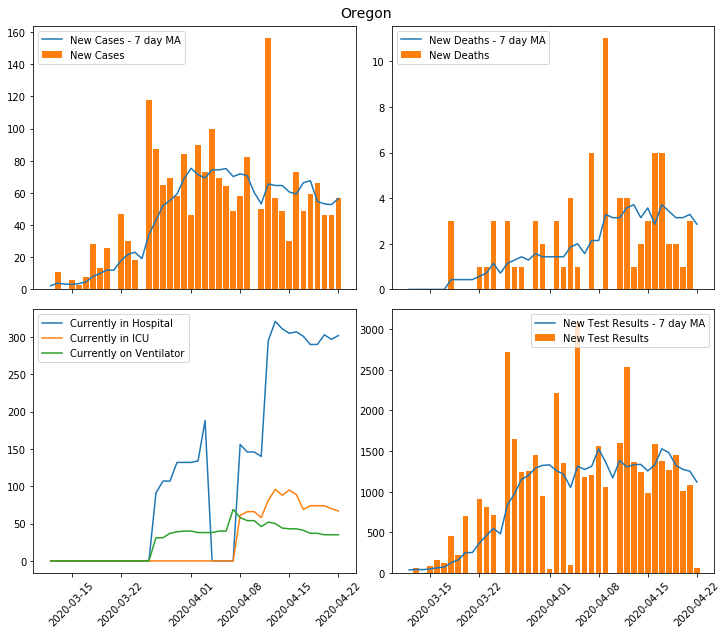

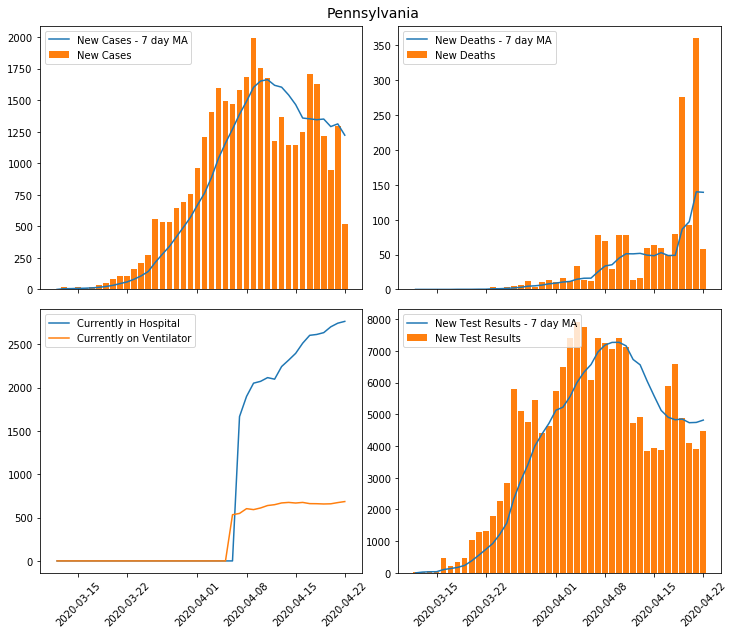

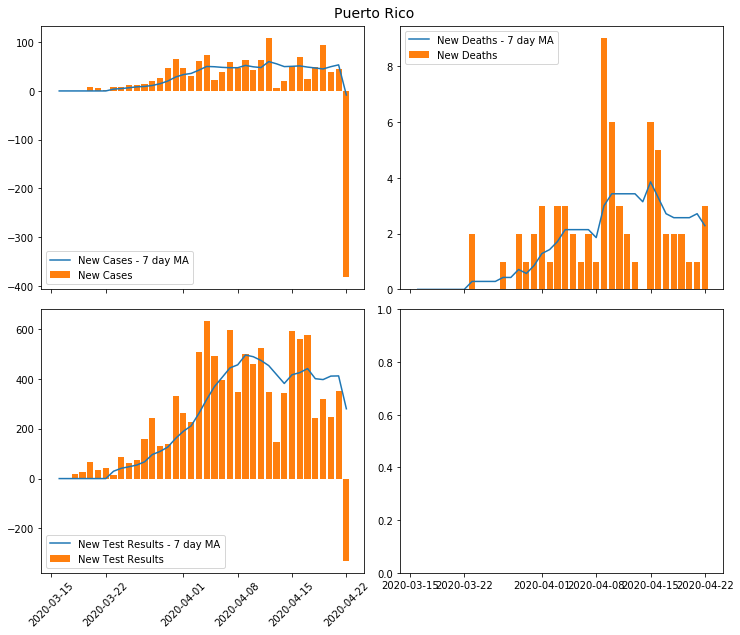

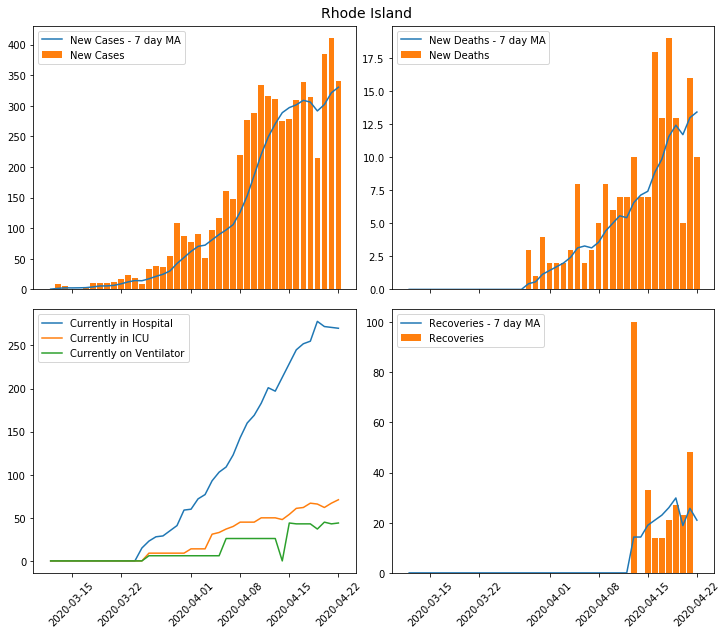

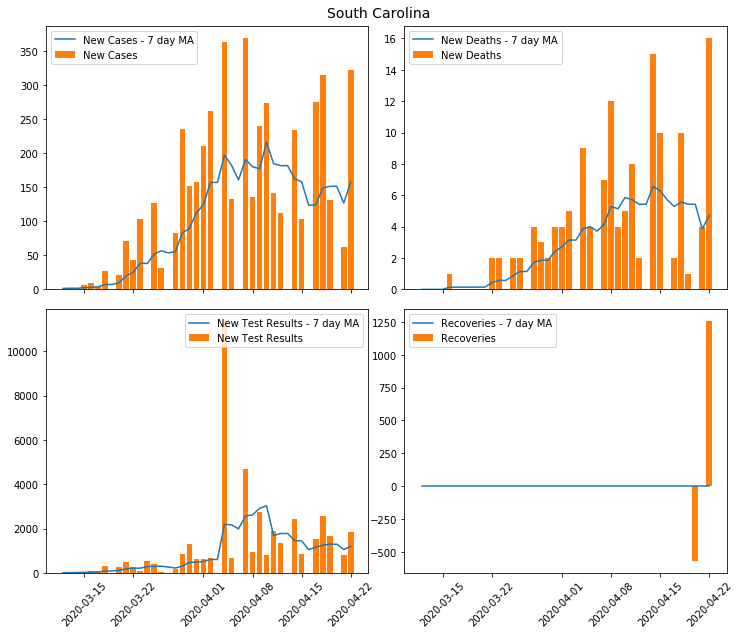

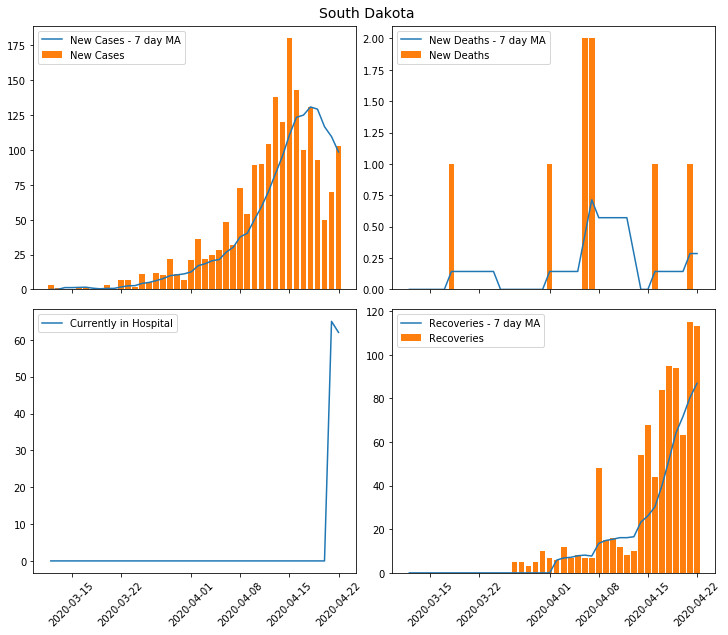

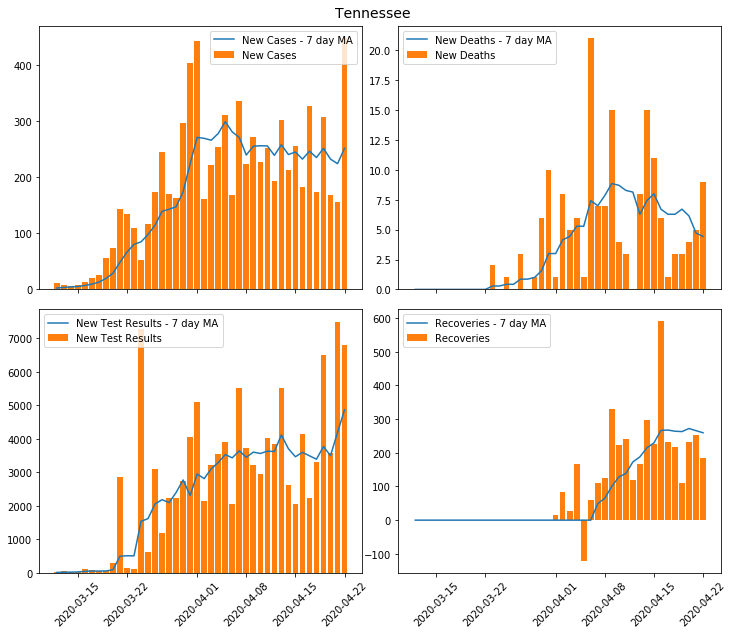

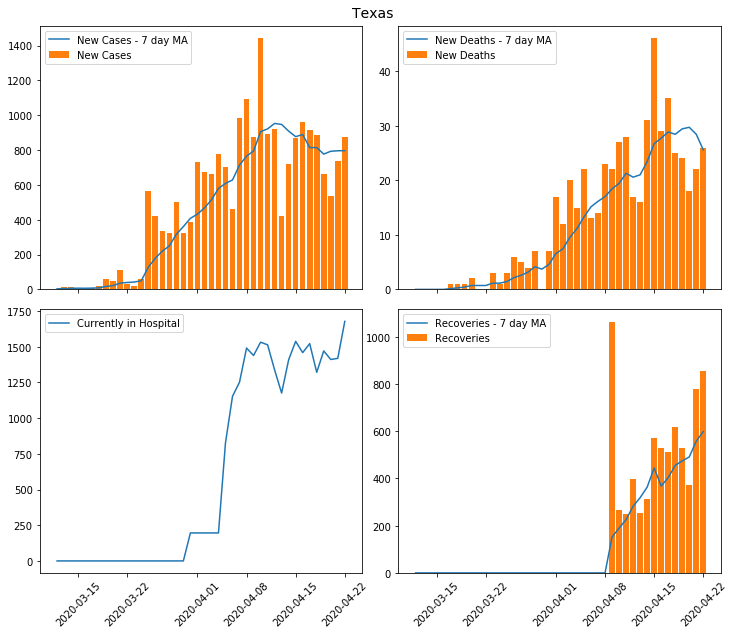

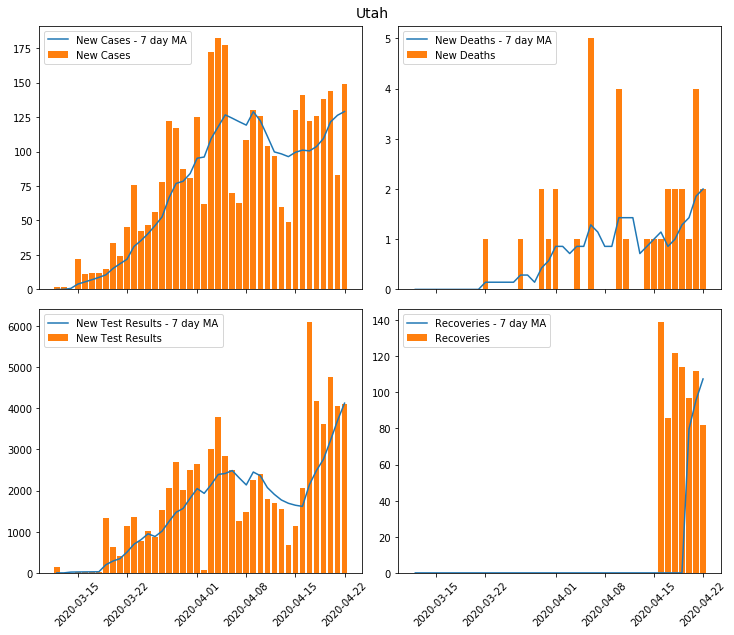

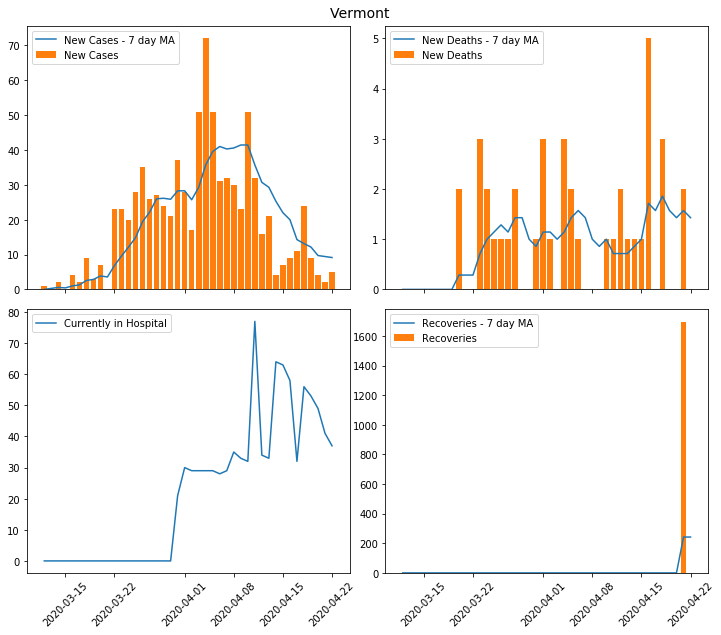

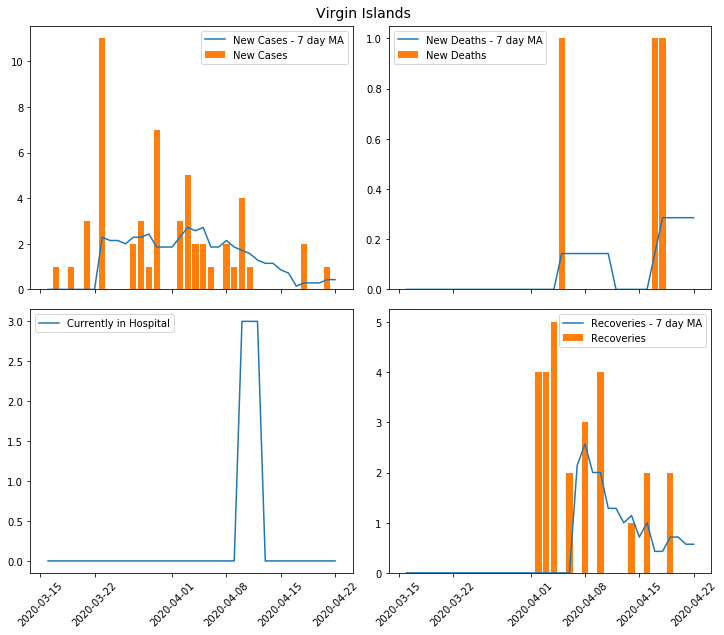

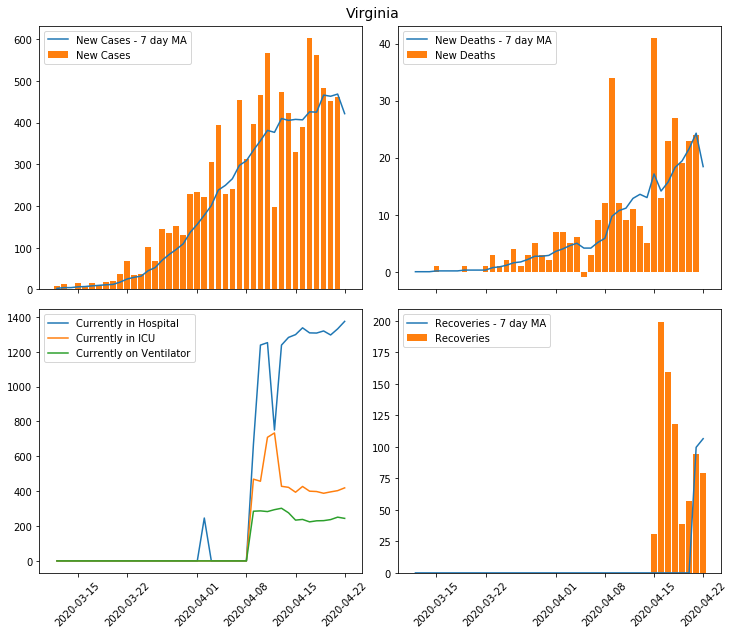

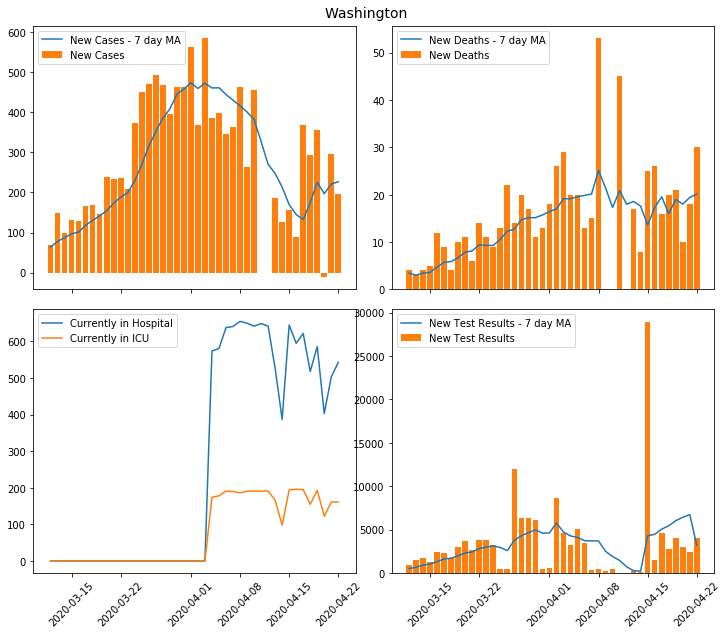

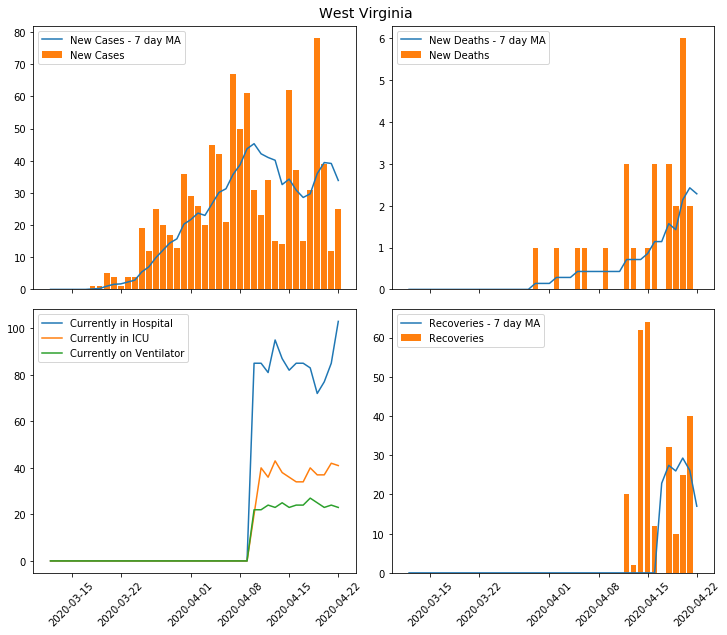

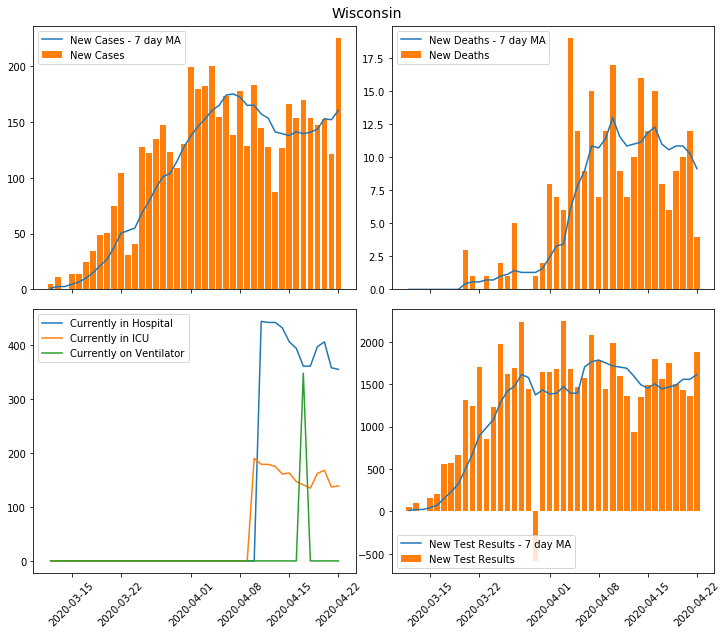

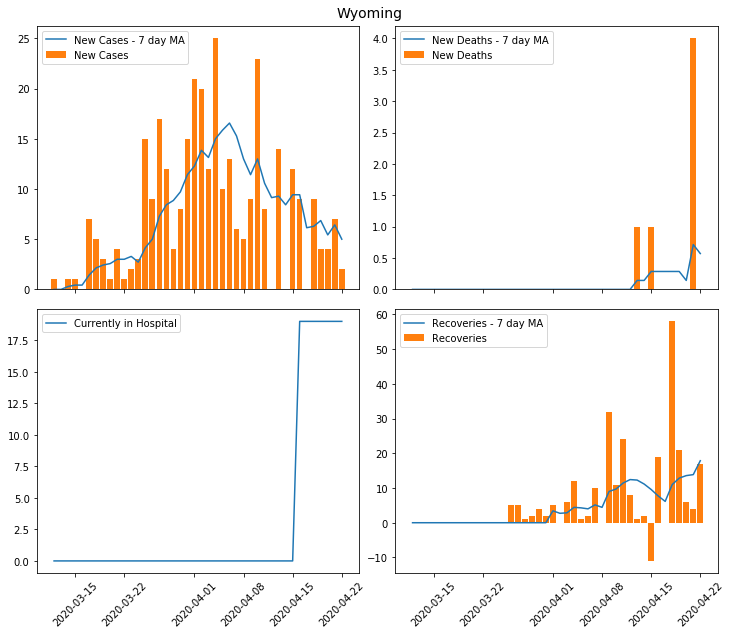

In [6]:
for state in los:
    plot_state(state)